# Using `gwent` to Generate Characteristic Strain Curves

Here we show examples of using the different classes in `gwent` for various detectors, both loading in from a file and generating with `gwent`, and binary black holes, both in the frequency and time domain.

First, we load important packages

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import os,sys

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib import cm
from matplotlib.legend_handler import HandlerNpoints, HandlerTuple

from scipy.constants import golden_ratio

import astropy.constants as const
import astropy.units as u
from astropy.cosmology import z_at_value
from astropy.cosmology import WMAP9 as cosmo

current_path = os.getcwd()
splt_path = current_path.split("/")
top_path_idx = splt_path.index('Research')
save_path_idx = splt_path.index('DetectorDesignSensitivities')
save_directory = "/".join(splt_path[0:save_path_idx+1])
top_directory = "/".join(splt_path[0:top_path_idx+1])

gwent_path = top_directory + '/gwent/'
phase_waveform_path = save_directory + '/Functions/'

sys.path.insert(0,gwent_path)
sys.path.insert(0,phase_waveform_path)

import waveform_Wphase as wwp
import gwent
import gwent.detector as detector
import gwent.binary as binary

Setting matplotlib and plotting preferences

In [3]:
def get_fig_size(width=7.,scale=1.0):
    #width = 3.36 # 242 pt
    base_size = np.array([1, 1/scale/golden_ratio])
    fig_size = width * base_size
    return(fig_size)
mpl.rcParams['figure.dpi'] = 160
mpl.rcParams['figure.figsize'] = get_fig_size()
mpl.rcParams['text.usetex'] = True
mpl.rc('font',**{'family':'serif','serif':['Times New Roman']})
mpl.rcParams['lines.linewidth'] = 2
mpl.rcParams['axes.labelsize'] = 12
mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12
mpl.rcParams['legend.fontsize'] = 10
colornorm = colors.Normalize(vmin=0.0, vmax=5.0)

We need to get the file directories to load in the instrument files.

In [4]:
load_directory = gwent.__path__[0] + '/LoadFiles'
save_directory += '/Figures/'

## Generating LISA designs with `gwent`

First we set a fiducial armlength and observation time-length

In [5]:
L = 2.5*u.Gm  #armlength in Gm
L = L.to('m')
LISA_T_obs = 4*u.yr

#### LISA Proposal 1

Values taken from the ESA L3 proposal, Amaro-Seaone, et al., 2017 (https://arxiv.org/abs/1702.00786)

In [6]:
f_acc_break_low = .4*u.mHz.to('Hz')*u.Hz
f_acc_break_high = 8.*u.mHz.to('Hz')*u.Hz
f_IMS_break = 2.*u.mHz.to('Hz')*u.Hz
A_acc = 3e-15*u.m/u.s/u.s
A_IMS = 10e-12*u.m

Background = False

LISA_prop1 = detector.SpaceBased('LISA',\
                          LISA_T_obs,L,A_acc,f_acc_break_low,f_acc_break_high,A_IMS,f_IMS_break,\
                          Background=Background)

## Generating Binary Black Holes with `gwent` in the Frequency Domain

We start with BBH parameters that exemplify the range of IMRPhenomD's waveforms from Khan, et al. 2016 https://arxiv.org/abs/1508.07253 and Husa, et al. 2016 https://arxiv.org/abs/1508.07250 

In [7]:
M = [1e6,65.0,1e10]
q = [1.0,18.0,1.0]
x1 = [0.95,0.0,-0.95]
x2 = [0.95,0.0,-0.95]
z = [3.0,0.093,20.0]

Uses the first parameter values and the `LISA_prop1` detector model for calculation of the monochromatic strain.

In [8]:
source_1 = binary.BBHFrequencyDomain(M[0],q[0],z[0],x1[0],x2[0],instrument=LISA_prop1)
source_1 = binary.BBHFrequencyDomain(M[0],q[0],z[1],x1[2],x2[2],instrument=LISA_prop1)

In [9]:
def waveform_stuff(source,t_c,phi_c,sigma_0):
    f_low = 1e-3
    N = source.nfreqs
    q = source.q
    x1 = source.chi1
    x2 = source.chi2
    fitcoeffs = source._fitcoeffs

    #M = m1+m2 #Total Mass
    #q = m2/m1 #Mass Ratio: Paper tested up to 18
    #eta = m1*m2/M**2 reduced mass: Paper tested up to 0.05 (q=18)
    eta = q/(q+1)**2
    x_PN = wwp.chi_PN(eta,x1,x2) #PN reduced spin parameter
    a_f = wwp.a_final(x1,x2,q,eta) #dimensionless spin

    ##################
    #Finds f_ringdown and f_damp from fit taken from <https://arxiv.org/abs/gr-qc/0512160>
    n = 0      #QNM indices
    l = 2
    m = 2
    numn = 3   #number of n's included in the table

    index = (l-2)*(2*l+1)*numn + (l-m)*numn + n
    f_fit = fitcoeffs[index][3:6]
    q_fit = fitcoeffs[index][6:9]

    omega_RD = f_fit[0]+f_fit[1]*(1-a_f)**f_fit[2]          #M omega_{lmn}
    tau = 2*(q_fit[0]+q_fit[1]*(1-a_f)**q_fit[2])/omega_RD  #tau_{lmn}/M = 2 Q_{lmn}/(M omega_{lmn})
    ########################
    f_RD = omega_RD/2/np.pi
    f_damp = 1/tau/2/np.pi

    Gamma1 = wwp.Lambda(eta,x_PN,4)
    Gamma2 = wwp.Lambda(eta,x_PN,5)
    Gamma3 = wwp.Lambda(eta,x_PN,6)

    f_peak = wwp.Calc_f_peak(f_RD,f_damp,[Gamma1,Gamma2,Gamma3])

    f1 = 0.014
    f3 = f_peak
    f2 = (f1+f3)/2

    f1_phase = 0.018
    f2_phase = 0.5*f_RD

    #cutoffFreq = wwp.Find_Cutoff_Freq(f_RD,f_damp,[Gamma1,Gamma2,Gamma3],pct_of_peak=0.01)
    cutoffFreq = 0.5
    #If lowest frequency is greater than cutoffFreq, then raise error.
    if f_low >= cutoffFreq:
        raise ValueError('Lower frequency bound (ie. f_low) must be lower than that of the merger ringdown.')

    Mf = np.logspace(np.log10(f_low),np.log10(cutoffFreq),N)
    #Mf_phase = np.logspace(log10(0.0035),log10(1.15*f_RD),N)
    #Mf_phase = np.logspace(log10(0.0035),log10(0.12),N)

    v1 = wwp.A_insp(f1,eta,x1,x2,x_PN)
    v2 = wwp.Lambda(eta,x_PN,3)
    v3 = wwp.A_MR(f3,f_RD,f_damp,[Gamma1,Gamma2,Gamma3])
    fund1 = wwp.DA_insp(f1,eta,x1,x2,x_PN)
    fund3 = wwp.DA_MR(f3,f_RD,f_damp,[Gamma1,Gamma2,Gamma3])

    #############################
    #Calculate Solutions to eqn 21 in intermediate region
    Del_solns = wwp.A_intermediate(f1,f2,f3,v1,v2,v3,fund1,fund3) # Solutions to eqn 21

    ##############################
    #Calculate all sections of waveform and Paste together
    indxf1 = np.argmin(np.abs(Mf-f1))
    indxfpeak = np.argmin(np.abs(Mf-f_peak))

    tmpinspiral = wwp.A_norm(Mf[0:indxf1+1],eta)*wwp.A_insp(Mf[0:indxf1+1],eta,x1,x2,x_PN)
    tmpintermediate = wwp.A_norm(Mf[indxf1+1:indxfpeak],eta)*wwp.A_int(Mf[indxf1+1:indxfpeak],Del_solns)
    tmpmergerringdown = wwp.A_norm(Mf[indxfpeak:],eta)*wwp.A_MR(Mf[indxfpeak:],f_RD,f_damp,[Gamma1,Gamma2,Gamma3])
    fullwaveform = np.hstack((tmpinspiral,tmpintermediate,tmpmergerringdown))

    ##############################
    #Calculate all section of waveform Phase
    indxf1_phase = np.argmin(np.abs(Mf-f1_phase))
    indxf2_phase = np.argmin(np.abs(Mf-f2_phase))

    #tc=0.0
    #phi_c = 0.0

    ##############################
    #Calculate Phase connections alpha0 and Beta0:
    dphi_ins = wwp.Dphi_ins(f1_phase,eta,x1,x2,x_PN,t_c)
    phi_ins = wwp.Phi_ins(f1_phase,eta,x1,x2,x_PN,t_c,phi_c,sigma_0)

    beta1 = eta*dphi_ins - wwp.Dphi_int(f1_phase,eta,x_PN,0.0)
    beta0 = eta*phi_ins - wwp.Phi_int(f1_phase,eta,x_PN,beta1,0.0)
    alpha1 = wwp.Dphi_int(f2_phase,eta,x_PN,beta1) - wwp.Dphi_MR(f2_phase,eta,x_PN,f_RD,f_damp,0.0)
    alpha0 = wwp.Phi_int(f2_phase,eta,x_PN,beta1,beta0) - wwp.Phi_MR(f2_phase,eta,x_PN,f_RD,f_damp,alpha1,0.0)


    dinspiral_phase = wwp.Dphi_ins(Mf[:indxf1_phase+1],eta,x1,x2,x_PN,t_c) 
    dintermediate_phase = (1/eta)*wwp.Dphi_int(Mf[indxf1_phase+1:indxf2_phase],eta,x_PN,beta1) 
    dmerger_ringdown_phase = (1/eta)*wwp.Dphi_MR(Mf[indxf2_phase:],eta,x_PN,f_RD,f_damp,alpha1) 


    inspiral_phase = wwp.Phi_ins(Mf[:indxf1_phase+1],eta,x1,x2,x_PN,t_c,phi_c,sigma_0) 
    intermediate_phase = (1/eta)*wwp.Phi_int(Mf[indxf1_phase+1:indxf2_phase],eta,x_PN,beta1,beta0) 
    merger_ringdown_phase = (1/eta)*wwp.Phi_MR(Mf[indxf2_phase:],eta,x_PN,f_RD,f_damp,alpha1,alpha0) 

    ############################
    #Join subsections of phase and amplitude 
    fullphase = np.hstack((inspiral_phase,intermediate_phase,merger_ringdown_phase))
    return [Mf,fullwaveform,fullphase,
            dinspiral_phase,dintermediate_phase,
            dmerger_ringdown_phase,f_RD,indxf1_phase,indxf2_phase]

In [42]:
#t_cs = [1e3,500.,100.,50.,0.,-50.,-100.,-500.,-1e3]
t_cs = np.arange(550,620,20)
print(t_cs)
#phi_cs = [0.,np.pi/2,np.pi,3*np.pi/2,2*np.pi]
phi_cs = [0.]
sigma_0 = 0.0

[550 570 590 610]


In [43]:
returns = []
#[f,h,fp,dinspiral_phase,
#     dintermediate_phase,
#     dmerger_ringdown_phase,
#     indxf1_phase,indxf2_phase]
for t_c in t_cs:
    for phi_c in phi_cs:
        returns.append(waveform_stuff(source_1,t_c,phi_c,sigma_0))

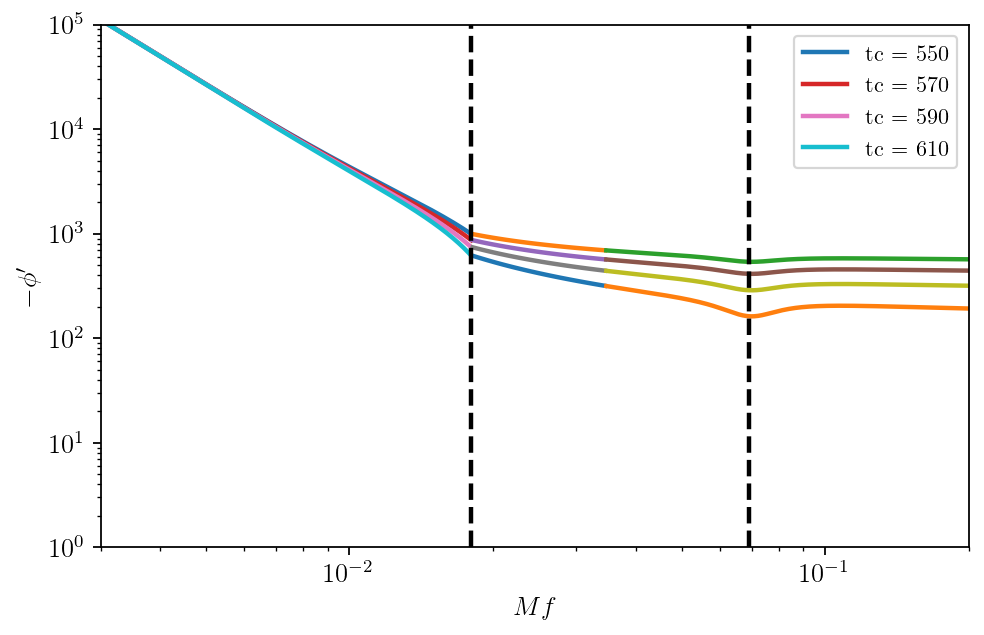

In [44]:
#plt.loglog(f,strain)
#plt.show()
for i in range(len(t_cs)):
    plt.loglog(returns[i][0][:returns[i][-2]+1],-returns[i][3],label='tc = {}'.format(t_cs[i]))
    plt.loglog(returns[i][0][returns[i][-2]+1:returns[i][-1]],-returns[i][4])
    plt.loglog(returns[i][0][returns[i][-1]:],-returns[i][5])
plt.legend()
plt.axvline(x=0.018,linestyle='--',color='k')
plt.axvline(x=returns[0][-3],linestyle='--',color='k')
plt.xlim([0.003,0.2])
plt.ylim([1,1e5])
plt.xlabel(r'$Mf$')
plt.ylabel(r'$-\phi^\prime$')
#plt.loglog(Mf,fullphase)
plt.show()

In [28]:
#plt.loglog(f,strain)
#plt.show()
plt.loglog(Mf[:indxf1_phase+1],inspiral_phase)
plt.loglog(Mf[indxf1_phase+1:indxf2_phase],intermediate_phase)
plt.loglog(Mf[indxf2_phase:],merger_ringdown_phase)
#plt.loglog(Mf,fullphase)
plt.show()

NameError: name 'Mf' is not defined

In [ ]:
plt.loglog(f,strain)
plt.axvline(x=0.018,linestyle='--',color='k')
plt.axvline(x=f_RD,linestyle='--',color='k')
plt.xlim([0.003,0.2])
plt.ylim([1,1e5])
plt.show()
plt.loglog(Mf,fullphase)
plt.axvline(x=0.018,linestyle='--',color='k')
plt.axvline(x=f_RD,linestyle='--',color='k')
plt.xlim([0.003,0.2])
plt.ylim([1,1e5])
plt.show()

Uses the first parameter values and the `aLIGO` detector model for calculation of the monochromatic strain.

In [ ]:
source_2 = binary.BBHFrequencyDomain(M[1],q[1],z[1],x1[1],x2[1],instrument=aLIGO_1)

Uses the first parameter values and the `SKA_WN` detector model for calculation of the monochromatic strain.

In [ ]:
source_3 = binary.BBHFrequencyDomain(M[2],q[2],z[2],x1[2],x2[2],instrument=SKA_WN)

Uses the first parameter values and the `ET` detector model for calculation of the monochromatic strain.

In [ ]:
source_4 = binary.BBHFrequencyDomain(M[1],q[0],z[1],x1[1],x2[1],instrument=ET_D)

In [ ]:
t_year = u.yr.to('s')*u.s
t_200_year = 200.*t_year

In [ ]:
source_6_q1_1 = binary.BBHFrequencyDomain(1e5,1.0,1.0,0.0,0.0,instrument=LISA_prop1)
source_6_q1_2 = binary.BBHFrequencyDomain(1e5,1.0,1.0,-0.95,-0.95,instrument=LISA_prop1)
source_6_q1_3 = binary.BBHFrequencyDomain(1e5,1.0,1.0,0.95,0.95,instrument=LISA_prop1)

source_6_q18_1 = binary.BBHFrequencyDomain(1e5,18.0,1.0,0.0,0.0,instrument=LISA_prop1)
source_6_q18_2 = binary.BBHFrequencyDomain(1e5,18.0,1.0,-0.95,-0.95,instrument=LISA_prop1)
source_6_q18_3 = binary.BBHFrequencyDomain(1e5,18.0,1.0,0.95,0.95,instrument=LISA_prop1)

source_8 = binary.BBHFrequencyDomain(1e2,1.0,1.0,0.0,0.0,instrument=LISA_prop1)
source_9 = binary.BBHFrequencyDomain(1e8,1.0,0.1,0.0,0.0,instrument=NANOGrav_WN)

#### Plot different binaries

## Plots of Entire GW Band

Displays only generated detectors: WN only PTAs, ESA L3 proposal LISA, aLIGO, and Einstein Telescope.

Displays three sources' waveform along with their monochromatic strain if they were observed by the initialized instrument at the detector's most sensitive frequency throughout its observing run (from left to right: `SKA_WN`,`LISA_prop1`,`ET`).

In [ ]:
fig,ax = plt.subplots()

#p_i_n, = ax.loglog(SKA_WN.fT,SKA_WN.h_n_f,color = cm.hsv(colornorm(0.5)),label = 'IPTA ~2030s')
p_i_n, = ax.loglog(NANOGrav_11yr_hasasia.fT,NANOGrav_11yr_hasasia.h_n_f, color = cm.hsv(colornorm(0.5)))
p_i_l, = ax.loglog(LISA_prop1.fT,LISA_prop1.h_n_f, color = cm.hsv(colornorm(1.75)))
p_i_a, = ax.loglog(aLIGO_1.fT,aLIGO_1.h_n_f,color = cm.hsv(colornorm(2.8)))
#ax.loglog(ET.fT,ET.h_n_f,color = cm.hsv(colornorm(2.5)),label = 'Einstein Telescope')

xlabel_min = -10
xlabel_max = 4
xlabels = np.arange(xlabel_min,xlabel_max+1)
xlabels = xlabels[1::]

ax.set_xticks(10.**xlabels)
print_xlabels = []
for x in xlabels:
    if abs(x) > 1:
        print_xlabels.append(r'$10^{%i}$' %x)
    elif x == -1:
        print_xlabels.append(r'$%.1f$' %10.**x)
    else:
        print_xlabels.append(r'$%.0f$' %10.**x)
ax.set_xticklabels([label for label in print_xlabels])

ax.set_xlim([5e-10, 7e3])
ax.set_ylim([3e-23, 4e-12])

ax.set_xlabel('Frequency [Hz]')
ax.set_ylabel('Characteristic Strain')
ax.legend([p_i_n,p_i_l,p_i_a,(p_s_8_l, p_s_8_p),(p_s_9_l, p_s_9_p)],
              ['NANOGrav: 11yr Data','LISA','aLIGO',
               r'$M = 10^{%.0f}$ $\mathrm{M}_{\odot}$, $z = %.1f$' %(np.log10(source_8.M.value),source_8.z),
               r'$M = 10^{%.0f}$ $\mathrm{M}_{\odot}$, $z = %.1f$' %(np.log10(source_9.M.value),source_9.z)],
              numpoints=1, handler_map={tuple: HandlerTuple(ndivide=None)},loc='upper right')
fig.savefig(save_directory+'detector_source_overlap.pdf',bbox_inches='tight')
plt.show()